In [10]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [11]:
# Declare file path convention here

###

s1 = 'E:/Old Downloads Folder/Research Stuff/Jupyter Notebooks/Coords Folder/Weather Station Coords/Los Angeles/'

###

In [12]:
# This finds the initial step, stopping point, and step size of the files in your directory

def findFiles(code):

    total_steps = 0

    i = 0

    first_file = False

    final = 0

    with os.scandir(s1 + code) as entries:

        bad_strings = [code, '_', '.txt']

        for entry in entries:

            file_name = entry.name

            for string in bad_strings:

                file_name = file_name.replace(string, '')

            if float(file_name) > final:

                final = float(file_name)

            if first_file == False:

                i = float(file_name)

                first_file = True

            total_steps += 1

    step = round((final - i)/(total_steps - 1), 5)
    
    return(i, final, step)

In [13]:
# Access the scale file of your code to find the Ovito -> Real world scale

def findScale(code):

    scale = 0

    openpath = s1 + code + '_scale.txt'

    with open(openpath) as f:

        f = f.read()

        scale = re.sub('[^0-9]', '', f)
        
    return float(scale)

In [14]:
# Create the dataframe that will hold our results

def createFrame(code):
    
    i, final, step = findFiles(code)
    
    column_names = ['Ovito Range', 'coeff', 'exp', 'R2']

    final_frame = pd.DataFrame(columns = column_names)
    
    s2 = '/' + code + '_'
    
    # The loop that does everything yeet

    while i <= final:

        # I could not figure out how to intelligently round the numbers so make sure to check this before running!!

        i = round(i, 5)
        
        openpath = s1 + code + s2 + str(i) + '.txt'

        with open(openpath) as file:

            data = pd.read_csv(file, sep = ',', names = ['Size'], skiprows = [0])

        data.index = data.index + 1

        data = data.reset_index()

        xdata = data['index']

        ydata = data['Size']

        variables, covariance = curve_fit(expFunc, xdata, ydata)

        temp_df = pd.DataFrame([[i, variables[0], variables[1], findR2(expFunc, xdata, ydata, variables)]], columns = column_names)

        final_frame = final_frame.append(temp_df, ignore_index = True)

        i += step
    
    return final_frame

In [15]:
# Finding the R^2 value of our curve fitting prediction
# Found here: https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit

def findR2(fun, x, y, popt):
    
    residuals = y - fun(x, *popt)

    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y - np.mean(y))**2)

    return 1 - (ss_res/ss_tot)

# Our function!

def expFunc(x, a, b):
    
    return a*x**b  

[Text(0, 0.5, 'Exponent'), Text(0.5, 0, 'Cluster Radius (ft)')]

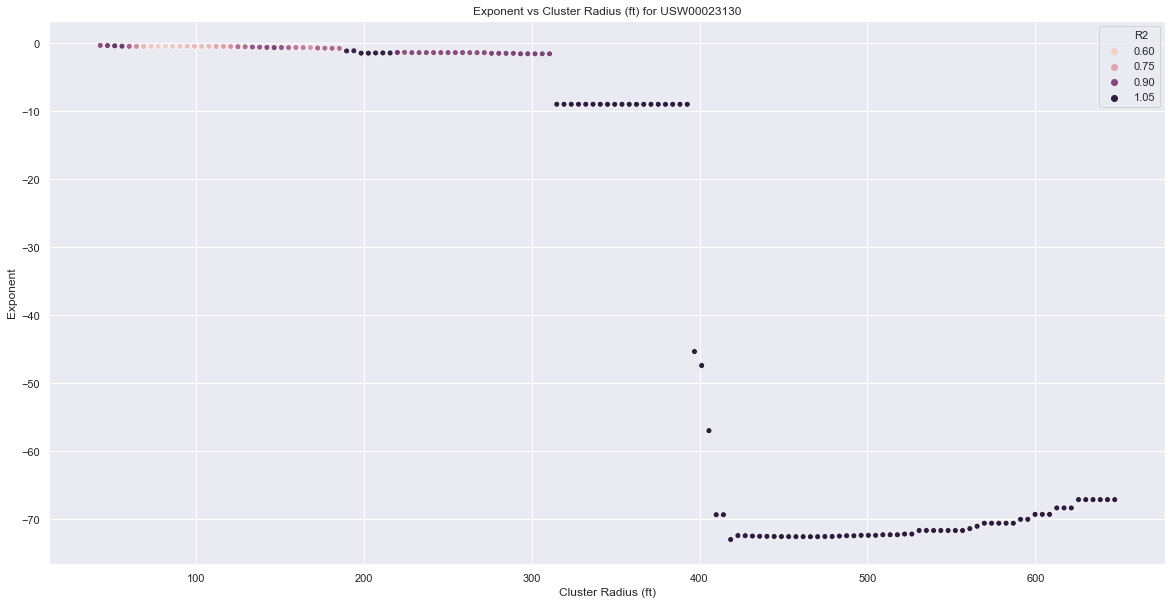

In [16]:
code = 'USW00023130'

final_frame = createFrame(code)

sns.set(rc={'figure.figsize':(20, 10)})

zip_dist = sns.scatterplot(x = final_frame['Ovito Range'] * findScale(code), y = final_frame.exp, hue = final_frame.R2)

zip_dist.set_title('Exponent vs Cluster Radius (ft) for ' + str(code))

zip_dist.set(ylabel = 'Exponent', xlabel = 'Cluster Radius (ft)')

In [8]:
# Let's see if we can identify drops in the data

def findDrops(code):
    
    final_frame = createFrame(code)
    
    prev_val = final_frame['exp'][0]
    
    min_val = prev_val
    
    max_val = final_frame['exp'][len(final_frame) - 1]

    drops = []

    for index, data in final_frame.iterrows():

        if abs(data['exp'] - prev_val) > 0.15 * abs(max_val - min_val):

            drops.append(data['Ovito Range'])

        prev_val = data['exp']
    
    return(drops[0] * findScale(code))

In [9]:
# This finds the drops for all the codes we have so far

codes = ['USW00023130', 'USW00093134']

for code in codes:
    
    line = findDrops(code)
    
    savepath = s1 + 'First Drops/' + code + '_first_drop.txt'
    
    with open(savepath, 'w+') as f:
        
        f.write(str(line))

E:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [9]:
# This saves the figure that's generated

fig = zip_dist.get_figure()

fig.savefig('Pictures and Figures/' + code + '_dist.png')